In [ ]:
!pip install pm4py

drive = True
dir = './data/'
if drive:
  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  sys.path.insert(0,'/content/drive/My Drive/Masterthesis')

  dir = '/content/drive/My Drive/Masterthesis/data'

import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py

In [53]:
# Read event_log from XES file and preprocess
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)
    return event_log

event_log = import_xes(dir + '/Hospital_log.xes')

# Accumulate case-specific inforamtion
age_cols = ['case:Age', 'case:Age:1', 'case:Age:2', 'case:Age:3', 'case:Age:4', 'case:Age:5']
treatment_cols = ['case:Treatment code', 'case:Treatment code:1', 'case:Treatment code:2', 'case:Treatment code:3', 'case:Treatment code:4', 'case:Treatment code:5', 'case:Treatment code:6', 'case:Treatment code:7', 'case:Treatment code:8', 'case:Treatment code:9', 'case:Treatment code:10', 'case:Treatment code:11', 'case:Treatment code:12', 'case:Treatment code:13', 'case:Treatment code:14', 'case:Treatment code:15']
specialism_cols = ['case:Specialism code', 'case:Specialism code:1', 'case:Specialism code:2', 'case:Specialism code:3', 'case:Specialism code:4', 'case:Specialism code:5', 'case:Specialism code:6', 'case:Specialism code:7', 'case:Specialism code:8', 'case:Specialism code:9', 'case:Specialism code:10', 'case:Specialism code:11', 'case:Specialism code:12', 'case:Specialism code:13', 'case:Specialism code:14', 'case:Specialism code:15']
diagnosis_cols = ['case:Diagnosis:1', 'case:Diagnosis:2', 'case:Diagnosis:3', 'case:Diagnosis:4', 'case:Diagnosis:5', 'case:Diagnosis:6', 'case:Diagnosis:7', 'case:Diagnosis:8', 'case:Diagnosis:9', 'case:Diagnosis:10', 'case:Diagnosis:11', 'case:Diagnosis:12', 'case:Diagnosis:13', 'case:Diagnosis:14', 'case:Diagnosis:15']
diagnosisCode_cols = ['case:Diagnosis code', 'case:Diagnosis code:1', 'case:Diagnosis code:2', 'case:Diagnosis code:3', 'case:Diagnosis code:4', 'case:Diagnosis code:5', 'case:Diagnosis code:6', 'case:Diagnosis code:7', 'case:Diagnosis code:8', 'case:Diagnosis code:9', 'case:Diagnosis code:10', 'case:Diagnosis code:11', 'case:Diagnosis code:12', 'case:Diagnosis code:13', 'case:Diagnosis code:14', 'case:Diagnosis code:15']
diagnosis_treatment_combi_id_cols = ['case:Diagnosis Treatment Combination ID', 'case:Diagnosis Treatment Combination ID:1', 'case:Diagnosis Treatment Combination ID:2', 'case:Diagnosis Treatment Combination ID:3', 'case:Diagnosis Treatment Combination ID:4', 'case:Diagnosis Treatment Combination ID:5', 'case:Diagnosis Treatment Combination ID:6', 'case:Diagnosis Treatment Combination ID:7', 'case:Diagnosis Treatment Combination ID:8', 'case:Diagnosis Treatment Combination ID:9', 'case:Diagnosis Treatment Combination ID:10', 'case:Diagnosis Treatment Combination ID:11', 'case:Diagnosis Treatment Combination ID:12', 'case:Diagnosis Treatment Combination ID:13', 'case:Diagnosis Treatment Combination ID:14', 'case:Diagnosis Treatment Combination ID:15']

event_log_new = event_log[['case:concept:name']].copy()
event_log_new.loc[:, 'age'] = event_log.loc[:, age_cols].apply(lambda row: int(np.min(row.dropna().unique())), axis=1)
event_log_new['Treatment codes'] = event_log[treatment_cols].apply(lambda row: ', '.join(map(str, np.unique(row.dropna().astype(int)))), axis=1)
event_log_new['Specialism codes'] = event_log[specialism_cols].apply(lambda row: ', '.join(map(str, np.unique(row.dropna().astype(int)))), axis=1)
event_log_new['Diagnosis codes'] = event_log[diagnosisCode_cols].apply(lambda row: ', '.join(map(str, np.unique(row.dropna().astype(str)))), axis=1)
event_log_new['Diagnosis Treatment Combination IDs'] = event_log[diagnosis_treatment_combi_id_cols].apply(lambda row: ', '.join(map(str, np.unique(row.dropna().astype(int)))), axis=1)
event_log_new['Diagnosis'] = event_log[diagnosis_cols].apply(lambda row: ', '.join(map(str, np.unique(row.dropna()))), axis=1)

# Extract start and end date
start_dates_cols = ['case:Start date', 'case:Start date:1', 'case:Start date:2', 'case:Start date:3', 'case:Start date:4', 'case:Start date:5', 'case:Start date:6', 'case:Start date:7', 'case:Start date:8', 'case:Start date:9', 'case:Start date:10', 'case:Start date:11', 'case:Start date:12', 'case:Start date:13', 'case:Start date:14', 'case:Start date:15']
end_dates_cols = ['case:End date', 'case:End date:1', 'case:End date:2', 'case:End date:3', 'case:End date:4', 'case:End date:5', 'case:End date:6', 'case:End date:7', 'case:End date:8', 'case:End date:9', 'case:End date:10', 'case:End date:11', 'case:End date:12', 'case:End date:13', 'case:End date:14', 'case:End date:15']
event_log[start_dates_cols] = event_log[start_dates_cols].apply(pd.to_datetime, errors='coerce', utc=True)
event_log[end_dates_cols] = event_log[end_dates_cols].apply(pd.to_datetime, errors='coerce', utc=True)
event_log_new.loc[:, 'Min Start Date'] = event_log.apply(lambda row: min(row[start_dates_cols].dropna(), default=pd.NaT), axis=1)
event_log_new.loc[:, 'Max End Date'] = event_log.apply(lambda row: max(row[end_dates_cols].dropna(), default=pd.NaT), axis=1)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

In [ ]:
for col in event_log.columns.sort_values():
    unique_values = event_log[col].unique().tolist()
    amount_nan = event_log[col].isna().sum()
    print("Name: {:50s} | unique values {:5d} | #NaNs in DF: {:6d}".format(col, len(unique_values), amount_nan))

In [ ]:
# I only want to keep one row per case
event_log_case_specific = event_log_new.drop_duplicates()
event_log_case_specific.set_index('case:concept:name', inplace=True)

In [54]:
# Save dfs to CSV-File
# event_log_case_specific.to_csv(dir + 'event_log_case_specific.csv')
event_log_new.to_csv(dir + 'event_log_modified.csv')

In [21]:
# Read dfs from CSV-File
event_log_new = pd.read_csv(dir + 'event_log_modified.csv', index_col=0)
event_log_case_specific = pd.read_csv(dir + 'event_log_case_specific.csv', index_col=0)

In [4]:
# cols specifies the attributes which should be taken into account to compute the uniqueness
def compute_uniqueness(df, cols):
    amount_cases = df.shape[0]
    unique_values_in_column = df[cols].drop_duplicates().shape[0]
    uniqueness_of_col = round(unique_values_in_column / amount_cases, 4) * 100
    return uniqueness_of_col


def get_all_combinations(cols, max_combi_size):
    all_column_combinations = []
    for r in range(1, max_combi_size + 1):
        all_column_combinations.extend(product(cols, repeat=r))

    # Filter the list to keep only (x, y) and not (y, x)
    sorted_list = []
    for tuple in all_column_combinations:
        sorted_list.append(set(sorted(list(tuple))))

    unique_sets = set(frozenset(s) for s in sorted_list)

    # Convert back to a list
    unique_sets_list = list(unique_sets)

    return unique_sets_list

In [5]:
# Get all column combinations up to a maximum amount of columns
all_column_combinations = get_all_combinations(cols=event_log_case_specific.columns, max_combi_size=3)

# Calculate uniqueness for each combination
uniqueness_of_col_combinations = {}
for columns in all_column_combinations:
    uniqueness = compute_uniqueness(event_log_case_specific, list(columns))
    uniqueness_of_col_combinations[columns] = uniqueness

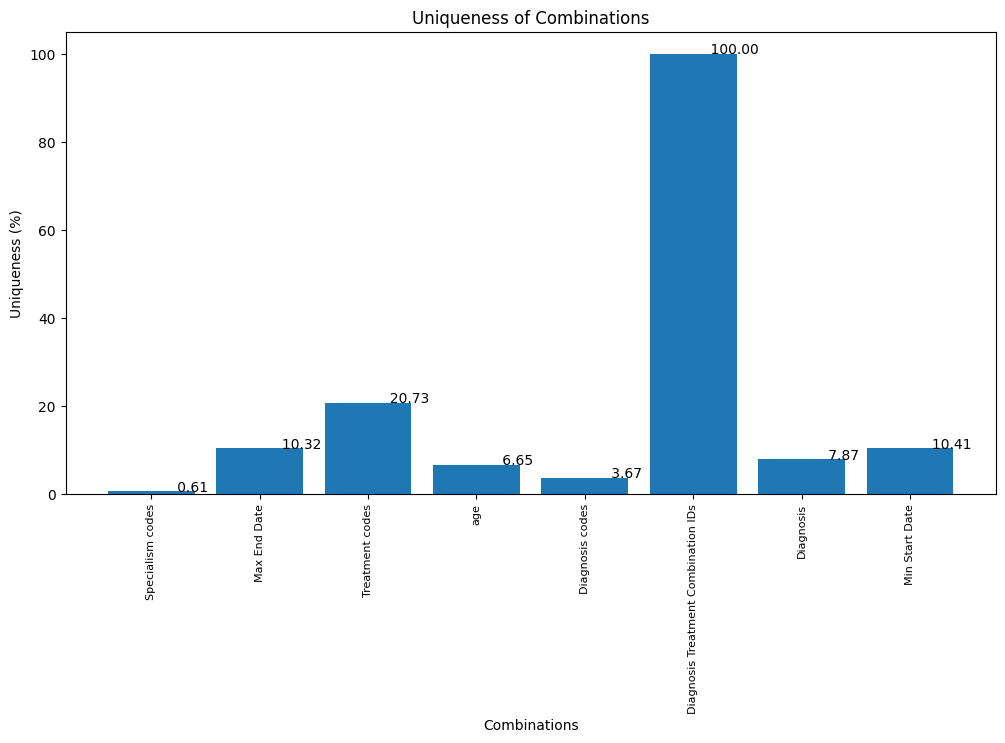

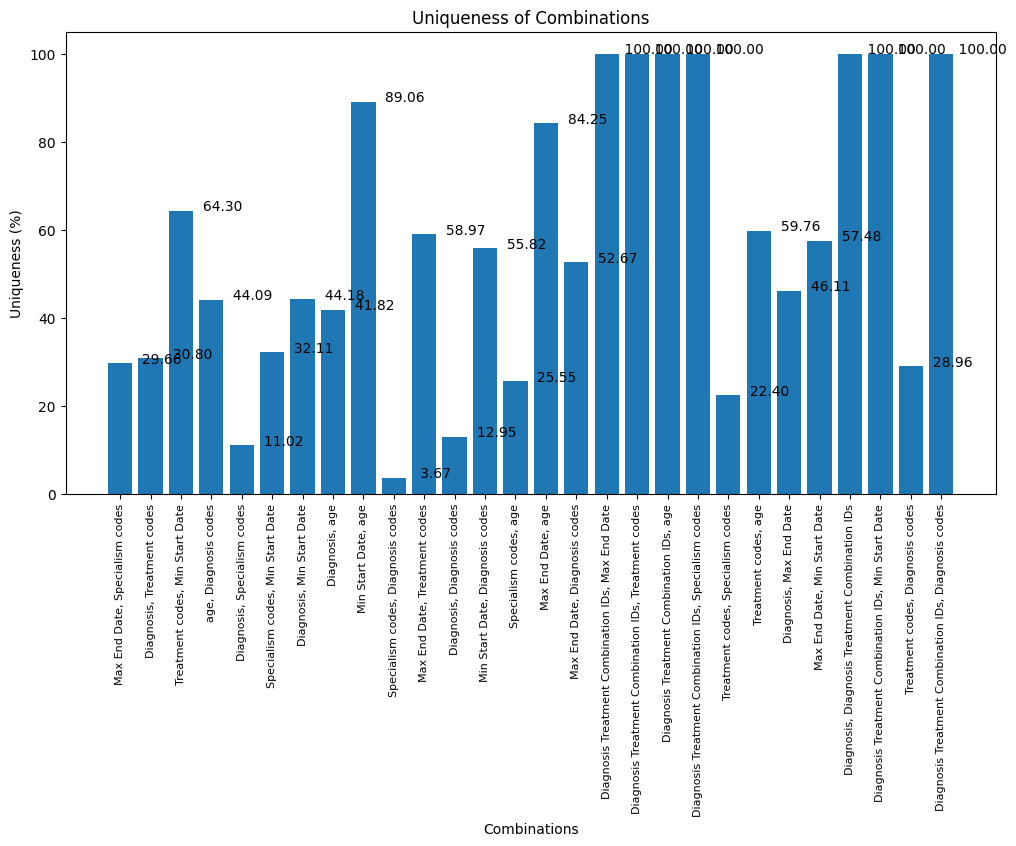

In [7]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],"{:10.2f}".format(y[i]))

for i in range(1, 3):
    filtered_dict = {key: value for key, value in uniqueness_of_col_combinations.items() if len(key) == i}
    combinations, values = zip(*filtered_dict.items())
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(combinations)), values, align='center')
    plt.xticks(range(len(combinations)), [', '.join(combination) for combination in combinations], rotation=90, fontsize=8)
    plt.xlabel('Combinations')
    plt.ylabel('Uniqueness (%)')
    plt.title('Uniqueness of Combinations')
    addlabels(combinations, values)
    plt.show()

<ipython-input-8-03b4b632b2e8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_columns.loc[:, 'Combination'] = df_two_columns.loc[:, 'Combination'].apply(sorted).copy()


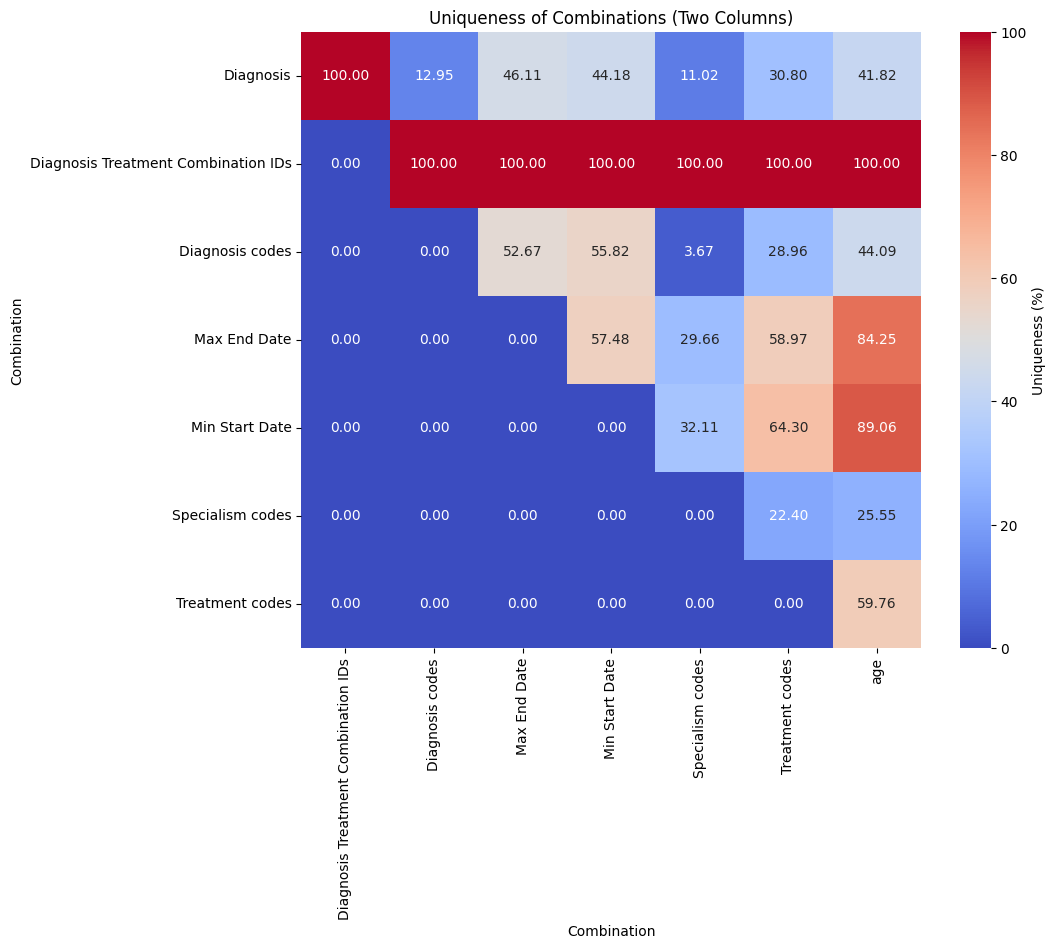

In [8]:
# Lets visualize the uniqueness of combinations of 2 columns
df = pd.DataFrame(list(uniqueness_of_col_combinations.items()), columns=['Combination', 'Uniqueness'])

# Extract combinations of size 2
df_two_columns = df[df['Combination'].apply(len) == 2]
df_two_columns.loc[:, 'Combination'] = df_two_columns.loc[:, 'Combination'].apply(sorted).copy()

# Create a pivot table for the heatmap
heatmap_data = df_two_columns.pivot_table(index=df_two_columns['Combination'].apply(lambda x: x[0]),
                                          columns=df_two_columns['Combination'].apply(lambda x: x[1]),
                                          values='Uniqueness').fillna(0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Uniqueness (%)'})
plt.title('Uniqueness of Combinations (Two Columns)')
plt.show()

In [9]:
# Combinations with 3 different columns and an uniqueness > a certain threshold
threshold = 75
# Filter all combinations which contain Diagnosis Treatment Combination ID (since the prob is always 100 %) and all combinations which contain the same column mutliple times
df_triples = df[df['Combination'].apply(lambda x: ('Diagnosis Treatment Combination IDs' not in x) and (len(set(x)) == len(x)))]
df_triples = df_triples[(df_triples['Combination'].apply(len) == 3) & (df_triples['Uniqueness'] >= threshold)]
df_triples['Combination'] = df_triples['Combination'].apply(sorted)

In [10]:
df_triples['Combination'] = df_triples['Combination'].apply(lambda x: ', '.join(x))
df_triples.drop_duplicates(inplace=True)
print(df_triples.sort_values("Uniqueness", ascending=False))

                                         Combination  Uniqueness
61              Diagnosis codes, Min Start Date, age       97.81
89                 Max End Date, Min Start Date, age       97.81
40                    Diagnosis, Min Start Date, age       97.46
27              Min Start Date, Treatment codes, age       97.38
71                Diagnosis codes, Max End Date, age       96.50
59                Max End Date, Treatment codes, age       96.15
85             Min Start Date, Specialism codes, age       94.75
88                      Diagnosis, Max End Date, age       92.21
80               Max End Date, Specialism codes, age       90.90
38     Diagnosis codes, Max End Date, Min Start Date       82.33
9      Max End Date, Min Start Date, Treatment codes       78.65
57  Diagnosis codes, Min Start Date, Treatment codes       78.30
39        Diagnosis, Min Start Date, Treatment codes       77.17
83    Diagnosis codes, Max End Date, Treatment codes       76.38


In [13]:
# Now let's focus on the uniqueness of traces
df_activites_per_case = event_log.groupby('case:concept:name')['Activity code'].agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()
df_activites_per_case

,case:concept:name,Activity code
0,00000000,"410100, 419100, 10107, 339486E, 410100, 419100..."
1,00000001,"10113, 410100, 419100, 10107, 411100, 419100, ..."
2,00000002,"10113, 411100, 411100, 419100, 411100, 411100,..."
3,00000003,"10113, 370000, 378149, 379999, 411100, 419100,..."
4,00000004,"10107, 355201, 370000, 370000, 370000, 370401,..."
...,...,...
1138,00001138,"339486E, 370000, 370000, 370000, 370401, 37040..."
1139,00001139,"355111, 370000, 370000, 370401, 370401C, 37040..."
1140,00001140,"370000, 370000, 370000, 370401, 370401C, 37040..."
1141,00001141,"330001B, 370000, 370000, 370000, 370401, 37040..."


In [14]:
# percentage of unique traces in the log
uniqueness_of_traces = compute_uniqueness(df_activites_per_case, 'Activity code')
print("{} %".format(uniqueness_of_traces))

85.83 %


In [15]:
# Compute the uniqueness of each activity --> With which probability can I reidentify a case (trace) given that a specific activity is contained in the trace
total_amount_traces = df_activites_per_case.shape[0]
total_amount_activities = event_log['Activity code'].unique().shape[0]
unique_activity_codes = event_log['Activity code'].unique()
uniqueness_containing_activity = pd.DataFrame(unique_activity_codes, columns=['activity code'])
counts = {}
appears = {}

def helper_count(row, activity_code):
    total_counts = str(row).count(str(activity_code))
    return 1 if total_counts > 0 else 0

for activity_code in unique_activity_codes:
    counts[str(activity_code)] = int(df_activites_per_case['Activity code'].apply(lambda row: str(row).count(str(activity_code))).values.sum())
    appears[str(activity_code)] = df_activites_per_case['Activity code'].apply(lambda row: helper_count(row, activity_code)).values.sum()

df_unique_activity_codes = pd.DataFrame([counts.keys(), counts.values(), appears.values()]).T
df_unique_activity_codes.columns = ['Activity code', 'total counts', 'containedInTrace']

# Compute uniqueness
df_unique_activity_codes['uniqueness'] = 1 - (df_unique_activity_codes['containedInTrace'] - 1) / total_amount_traces

print(df_unique_activity_codes.sort_values('uniqueness', ascending=False))

    Activity code total counts containedInTrace uniqueness
672       375143B            1                1        1.0
539       389370R            1                1        1.0
548       375561E            1                1        1.0
504        377450            1                1        1.0
545       378452A            1                1        1.0
..            ...          ...              ...        ...
9        370407.0         4275              729    0.36308
7          370000        15353              804   0.297463
15         379999         9008              804   0.297463
32         411100         5239              958    0.16273
1          419100         2171             1110   0.029746

[673 rows x 4 columns]


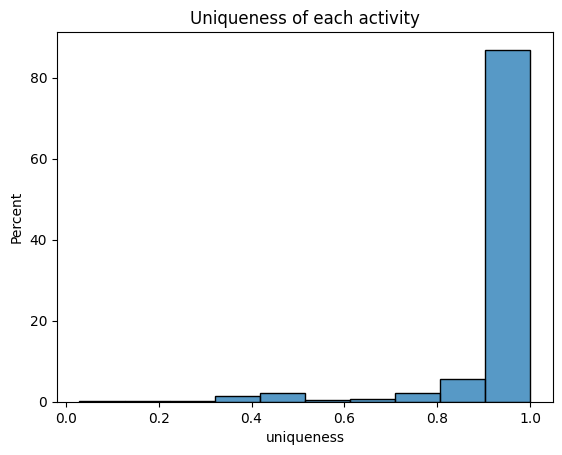

Bin 1 -  Count: 1, Percentage: 0.15 %
Bin 2 -  Count: 1, Percentage: 0.15 %
Bin 3 -  Count: 2, Percentage: 0.3 %
Bin 4 -  Count: 10, Percentage: 1.49 %
Bin 5 -  Count: 15, Percentage: 2.23 %
Bin 6 -  Count: 3, Percentage: 0.44999999999999996 %
Bin 7 -  Count: 5, Percentage: 0.74 %
Bin 8 -  Count: 14, Percentage: 2.08 %
Bin 9 -  Count: 37, Percentage: 5.5 %
Bin 10 -  Count: 585, Percentage: 86.92 %

192 activities are completely unique


In [16]:
def print_and_visualize_hist_plot(df, col_name, amount_bins, hist_title, total_amount):

    sns.histplot(df[col_name], bins=amount_bins, stat='percent').set(title=hist_title)
    plt.show()

    hist_values, bin_edges = np.histogram(df[col_name], bins=amount_bins)

    # Print out the histogram values
    for i in range(len(hist_values)):
        print(f"Bin {i+1} -  Count: {hist_values[i]}, Percentage: {round(hist_values[i]/total_amount, 4) * 100} %")

    # Count of activities which have a uniqueness of 100%
    amount_completely_unique_activities = df[df[col_name] == 1][col_name].count()
    print("\n{} activities are completely unique".format(amount_completely_unique_activities))

print_and_visualize_hist_plot(df=df_unique_activity_codes, col_name='uniqueness', amount_bins=10, hist_title='Uniqueness of each activity',total_amount=total_amount_activities)

In [17]:
# unique traces in the event log not considering the order of execution of the activities and how many times each activity was executed

df_activites_per_case_as_set = df_activites_per_case
# Convert String to list, then to set to remove duplicates and then convert set back to list to order the elements. Finally, convert list back to a String
df_activites_per_case_as_set['Ordered Activity Set'] = df_activites_per_case['Activity code'].apply(lambda row: ", ".join(sorted(list(set(row.split(", "))))))

# Compute Uniqueness
unordered_set_uniquness_of_activities = compute_uniqueness(df_activites_per_case_as_set, cols=['Ordered Activity Set'])
print("{} % of traces are unique not considering the order of execution of the activities and how many times each activity was executed".format(unordered_set_uniquness_of_activities))

77.60000000000001 % of traces are unique not considering the order of execution of the activities and how many times each activity was executed


In [22]:
# Let's have a look at combinations of activities of size 2: Given that I know 2 activities which are contained in a specific log,
# How likely is a direct identification of a specific case?
# Neglecting the order or the amount of executions of each activity

def compute_uniqueness_activities(df, row):
    act1 = str(row[0])
    act2 = str(row[1])
    frequency = df[df.loc[:, 'Activity code'].str.contains(act1) & df.loc[:, 'Activity code'].str.contains(act2)].shape[0]
    return frequency if not frequency == 0 else df.shape[0]


not_unique_activities = df_unique_activity_codes['Activity code'].values
all_column_combinations = get_all_combinations(cols=list(not_unique_activities), max_combi_size=2)
df_all_column_combinations = pd.DataFrame(all_column_combinations, columns=['Activity 1', 'Activity 2'])
df_all_column_combinations['uniqueness'] = 1 - df_all_column_combinations.apply(lambda row: compute_uniqueness_activities(df_activites_per_case, row), axis=1) / df_activites_per_case.shape[0]

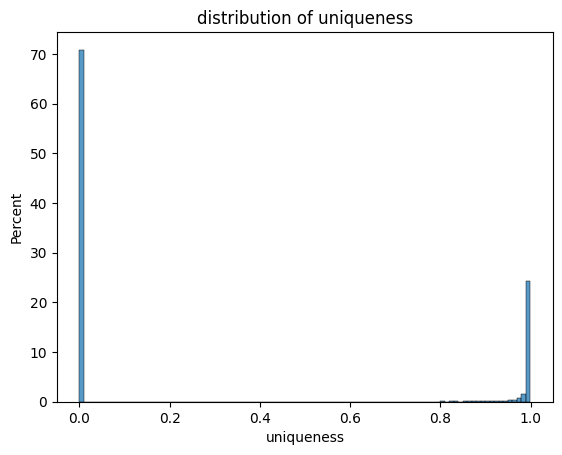

Bin 1 -  Count: 160657, Percentage: 70.84 %
Bin 2 -  Count: 0, Percentage: 0.0 %
Bin 3 -  Count: 0, Percentage: 0.0 %
Bin 4 -  Count: 0, Percentage: 0.0 %
Bin 5 -  Count: 0, Percentage: 0.0 %
Bin 6 -  Count: 0, Percentage: 0.0 %
Bin 7 -  Count: 0, Percentage: 0.0 %
Bin 8 -  Count: 0, Percentage: 0.0 %
Bin 9 -  Count: 0, Percentage: 0.0 %
Bin 10 -  Count: 0, Percentage: 0.0 %
Bin 11 -  Count: 0, Percentage: 0.0 %
Bin 12 -  Count: 0, Percentage: 0.0 %
Bin 13 -  Count: 0, Percentage: 0.0 %
Bin 14 -  Count: 0, Percentage: 0.0 %
Bin 15 -  Count: 0, Percentage: 0.0 %
Bin 16 -  Count: 0, Percentage: 0.0 %
Bin 17 -  Count: 0, Percentage: 0.0 %
Bin 18 -  Count: 1, Percentage: 0.0 %
Bin 19 -  Count: 0, Percentage: 0.0 %
Bin 20 -  Count: 0, Percentage: 0.0 %
Bin 21 -  Count: 0, Percentage: 0.0 %
Bin 22 -  Count: 0, Percentage: 0.0 %
Bin 23 -  Count: 0, Percentage: 0.0 %
Bin 24 -  Count: 0, Percentage: 0.0 %
Bin 25 -  Count: 0, Percentage: 0.0 %
Bin 26 -  Count: 0, Percentage: 0.0 %
Bin 27 -  Coun

In [23]:
df_all_column_combinations['combination'] = df_all_column_combinations.apply(lambda row: str(row['Activity 1']) + " - " + str(row['Activity 2']), axis=1)
# Save df to CSV-File
df_all_column_combinations.to_csv(dir + 'df_all_column_combinations.csv')
print_and_visualize_hist_plot(df=df_all_column_combinations, col_name='uniqueness', amount_bins=100, hist_title='distribution of uniqueness', total_amount=df_all_column_combinations['combination'].unique().shape[0])

In [24]:
df_all_column_combinations = df_all_column_combinations[df_all_column_combinations['uniqueness'] > 0]
print(df_all_column_combinations[df_all_column_combinations['uniqueness'] >= 0.99])

       Activity 1 Activity 2  uniqueness        combination
0          387877     370606    0.999125    387877 - 370606
2          378644     619600    0.995626    378644 - 619600
3         378216A     370496    0.999125   378216A - 370496
5          379999    375581K    0.998250   379999 - 375581K
12         419100     389290    0.998250    419100 - 389290
...           ...        ...         ...                ...
226783    388118R    370712B    0.995626  388118R - 370712B
226789     413413     378729    0.998250    413413 - 378729
226792     710170    339880A    0.999125   710170 - 339880A
226796    376467E     335571    0.999125   376467E - 335571
226798    377498A     377450    0.999125   377498A - 377450

[54366 rows x 4 columns]


In [25]:
# Examples of linkage attacks
age = 60
diag_teat_combi_id = "617121"
patient_identified_by_diag_treat_combi_id = event_log_case_specific[event_log_case_specific['Diagnosis Treatment Combination IDs'].str.contains(diag_teat_combi_id)].index.values[0]
act_1 = '370135S'
act_2 = '337409'
patient_identified_by_activities = df_activites_per_case[df_activites_per_case['Activity code'].str.contains(act_1) & df_activites_per_case['Activity code'].str.contains(act_2)].index.values[0]
print("Patient with Diagnosis Treatment Combination IDs of {}: {}".format(diag_teat_combi_id, patient_identified_by_diag_treat_combi_id)) # Uniqueness: 100%
print("# patients with an age of 60 at the beginning of their treatment: {} ". format(event_log_case_specific[event_log_case_specific['age'] == age].shape[0]))
print("Patient with activity {} and {}: {}".format(act_1, act_2, patient_identified_by_activities))

Patient with Diagnosis Treatment Combination IDs of 617121: 106
# patients with an age of 60 at the beginning of their treatment: 30: 
Patient with activity  370135S and 337409: 14


In [63]:
print(len(event_log['Activity code'].drop_duplicates()))
event_log[['Activity code', 'concept:name']].drop_duplicates()

673


,Activity code,concept:name
0,410100,1e consult poliklinisch
1,419100,administratief tarief - eerste pol
2,10107,verlosk.-gynaec. korte kaart kosten-out
3,339486E,echografie - genitalia interna
6,390520,simulator - gebruik voor aanvang megavol
...,...,...
148767,980929,eerste hulp - niet seh afdeling - elders
149157,335512,buik - second-look-oper.ovariumca
149231,376845,itraconazol mbv hplc
149704,375143A,bepaling hepatitis-be-antigeen
